# Step 4: Calculate clone frequencies

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
# %load ../../barcode_scripts/calculate_clone_frequencies.py
import sys, os, glob, csv, re
import string, math, numpy
import argparse
from copy import deepcopy
import pandas
import matplotlib
from matplotlib import pyplot

In [4]:
try:
    from ltrack import config
    from ltrack import local_matplotlibrc
    from ltrack.lineage import file_parser as file_parser
    import ltrack.lineage.inference_params as inference_params
    import ltrack.lineage.file_parser as file_parser
    from ltrack.lineage.fitness_estimator import *
except ImportError:
    print("Please install the LineageTracking package by running the command line 'pip install .' in the lineage_tracking repository's root directory.")
    raise
except: raise

In [5]:
project_name = os.path.basename(os.getcwd())

In [6]:
population = project_name

In [7]:
population

'LT_5epochs'

In [8]:
def insert_clone(barcode,parental_barcode, clone_dict, full_dataset):

    if parental_barcode in clone_dict.keys():
        # there is a parental lineage with this barcode: insert barcode into dict
        epoch = len(barcode.split("_")) - 1
        p_ID = "_".join(barcode.split("_")[:-1])
        last_ID = barcode.split("_")[-1]
        clone_dict[barcode] = deepcopy(full_dataset[epoch][p_ID][last_ID])

        # then, reduce frequency of parent clone by frequency of this child lineage
        parent_epoch = len(parental_barcode.split("_")) - 1
        difference = epoch - parent_epoch
        clone_dict[parental_barcode].freqs -= clone_dict[barcode].freqs
    else:
        if len(parental_barcode.split("_"))>1:
            # we may not have tried the right parent barcode. look for an earlier parent before inserting lineage
            insert_clone(barcode,"_".join(parental_barcode.split("_")[:-1]),clone_dict,full_dataset)
        else:
            # parent not found. simply insert clone into dict
            epoch = len(barcode.split("_")) - 1
            p_ID = "_".join(barcode.split("_")[:-1])
            last_ID = barcode.split("_")[-1]
            clone_dict[barcode] = deepcopy(full_dataset[epoch][p_ID][last_ID])

In [9]:

timepoints, data, counts = file_parser.get_data(population,
                                                config.barcode_data_root_directory,
                                                as_matrix = False
                                               )

clone_dict = {}

clone_list_files = [config.clone_data_directory+population+'_clone_list.tsv']
for filename in clone_list_files:
    f = open(filename,'r')
    for row in csv.reader(f,delimiter = '\t'):
        barcodes = row[0]
        parental_ID = "_".join(barcodes.split("_")[:-1])
        insert_clone(barcodes,parental_ID,clone_dict,data)
    f.close()

INFO:root:Processing population LT_5epochs.
INFO:root:Reading files.
INFO:root:Reading files complete.


In [11]:
timepoints

[array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 array([20., 30., 40., 50., 60., 70., 80., 90.]),
 array([40., 50., 60., 70., 80., 90.]),
 array([60., 70., 80., 90.]),
 array([80., 90.])]

In [12]:
[len(clone.freqs) for clone in clone_dict.values()]

[10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10]

In [13]:
# Create pandas dataframe to export the data.
columns = ['POP']+['BC'] + [int(d) for d in timepoints[0]]
df = pandas.DataFrame(columns=columns, data={})
for clone_ID, lineage in clone_dict.items():
    row = {"POP": population,
           "BC": clone_ID
          }
    freq_dict = dict(zip([int(t) for t in timepoints[0]], lineage.freqs.tolist()))
    row.update(freq_dict)
    df.append(pandas.Series(row), ignore_index=True)
    df = pandas.concat([df,pandas.DataFrame(pandas.Series(row)).T], ignore_index=True)

In [14]:
df.to_csv(
    config.clone_data_directory+'%s-clone_frequencies.tsv' % (population),
    index=False,
    sep="\t")

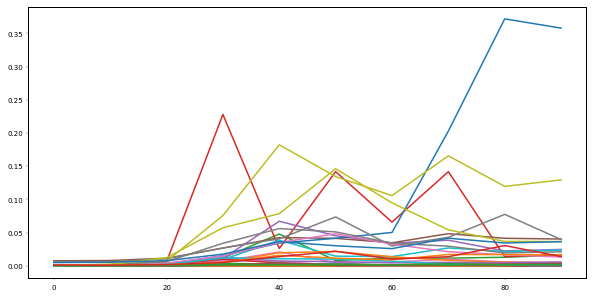

In [15]:
df.T.iloc[2:].plot()
pyplot.legend([])